*Copyright (C) 2022 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

---

# Three Factor Learning with Lava 

**Motivation**: This tutorial demonstrates how Lava users can define and implement three factor learning rules using a software model of Loihi's learning engine.

#### This tutorial assumes that you:
- have the [Lava framework installed](../../in_depth/tutorial01_installing_lava.ipynb "Tutorial on Installing Lava")
- are familiar with [Process interfaces in Lava](../../in_depth/tutorial02_processes.ipynb "Tutorial on Processes")
- are familiar with [ProcessModel implementations in Lava](../../in_depth/tutorial02_process_models.ipynb "Tutorial on ProcessModels")
- are familiar with how to [connect Lava Processes](../../in_depth/tutorial05_connect_processes.ipynb "Tutorial on connecting Processes")
- are familiar with how to [implement a custom learning rule](../../in_depth/tutorial08_stdp.ipynb "Tutorial on STDP")

This tutorial demonstrates how the Lava Learning API can be used for simulation of three-factor learning rules. We first instantiate a high-level interface for the reward-modulated spike-timing dependent plasticity (R-STDP) rule defined in the Lava Process Library. We then execute a simulation of a spiking neural network in which localized, graded reward factors are mapped to specific plastic synapses, demonstrating Lava support for this new Loihi 2 learning capability. Finally, we demonstrate how users can define their own custom, three-factor learning rule interfaces and implement custom post-synaptic trace dynamics in simulation, as supported on Loihi 2 through microcoded post-synaptic neuron instructions. With these capabilities, Lava now provides support for many of the latest neuro-inspired learning algorithms under study!

### Defining three-factor learning rule interfaces in Lava

The Lava learning API can be used to represent a wide range of local learning rules that obey Loihi's sum-of-product learning rule form. Users can define define custom, reusable learning rule interfaces atop the full Lava learning engine equation parser. Here, we import a reusable interface for reward-modulated spike-timing dependent plasticity (R-STDP) that is now part of the standard Lava Process Library.

#### Reward-modulated Spike-Timing Dependent Plasticity (R-STDP) learning rule

Reward-modulated STDP is a three-factor learning rule that can explain how behaviourly relevant adaptive changes in a complex network of spiking neurons could be achieved in a self-organizing manner through local synaptic plasticity. A third, reward signal modulates the outcome of the pairwise two-factor learning rule STDP. The implementation of the R-STDP described below is adapted from [Neuromodulated Spike-Timing-Dependent Plasticity](https://www.frontiersin.org/articles/10.3389/fncir.2015.00085/full "Neuromodulated Spike-Timing-Dependent Plasticity, and Theory of Three-Factor Learning Rules").

Synaptic weights, $W$, are modulated as a function of the eligibility trace $E$ and reward term $R$:

$$\dot{W} = R \cdot E$$

The synaptic eligibility trace stores a temporary memory of the STDP outcome that persists through the epoch when a delayed reward signal is received. Defining the learning window of a traditional Hebbian STDP as $STDP(pre, post)$, where "pre" represents the pre-synaptic activity of a synapse and "post" represents the state of the post-synaptic neuron, the synaptic eligibility trace dynamics have the form:

$$\dot{E} = - \frac{E}{\tau_e} + STDP(pre, post)$$

NOTE: Learning parameters are adapted from online implemention of [Spike-Timing Dependent Plasticity (STDP)](http://www.scholarpedia.org/article/Spike-timing_dependent_plasticity "Spike-Timing Dependent Plasticity") and can vary based on implementation. 

In [1]:
from lava.proc.learning_rules.r_stdp_learning_rule import RewardModulatedSTDP

R_STDP = RewardModulatedSTDP(learning_rate=1,
                             A_plus=-2,
                             A_minus=2,
                             pre_trace_decay_tau=10,
                             post_trace_decay_tau=10,
                             pre_trace_kernel_magnitude=16,
                             post_trace_kernel_magnitude=16,
                             eligibility_trace_decay_tau=0.5,
                             t_epoch=1
                             )

### Defining a simple learning network with localized reward signals

We can now define a simple spiking network in which connections are modified according to our R-STDP learning rule. The core of the learning network is comprised of one pre-synaptic leaky-integrate-and-fire (LIF) neuron and two post-synaptic LIF neurons, all of which are driven by binary spiking inputs. The pre- and post-synaptic neurons are connected via a LearningDense Process, which learns weights according to the R-STDP learning rule. The binary spiking inputs drive the pre- and post- populations to affect the dynamics of the R-STDP eligibility trace.

The network's post-synaptic population also receives localized, graded reward spikes. The post-synaptic neurons transform the graded reward spikes to localized reward traces, which act as targeted modulators to specific plastic synapses within the LearningDense process. This tutorials now includes a RSTDPLIF Process, used for post-synaptic neurons that can each compute up to two custom reward traces or "third factor" modulators. 

_NOTE : Though the RSTDPLIF Process can currently only be executed on CPU backend, it is modeled from Loihi 2's ability to compute custom post-traces in microcoded neuron instructions. Lava support for on-chip execution will be available soon!_

![R_STDP_architecture](https://raw.githubusercontent.com/lava-nc/lava-docs/main/_static/images/tutorial_learning/r_stdp_tutorial_architecture.svg)

In [2]:
import numpy as np

SELECT_TAG = "floating_pt"

#### Initialize network parameters and weights

In [3]:
# LIF neuron parameters 
du = 1
dv = 1
vth = 240

# Pre-synaptic neuron parameters  
num_neurons_pre = 1
shape_lif_pre = (num_neurons_pre, )
shape_conn_pre = (num_neurons_pre, num_neurons_pre)

# SpikeIn -> pre-synaptic LIF connection weight 
wgt_inp_pre = np.eye(num_neurons_pre) * 250


# Post-synaptic neuron parameters
num_neurons_post = 2
shape_lif_post = (num_neurons_post, )
shape_conn_post = (num_neurons_post, num_neurons_pre)

# SpikeIn -> post-synaptic LIF connection weight 
wgt_inp_post = np.eye(num_neurons_post) * 250


# Third-factor input weights
# Graded SpikeIn -> post-synaptic LIF connection weight 
wgt_inp_reward = np.eye(num_neurons_post) * 100


# pre-LIF -> post-LIF connection initial weight (learning-enabled)
# Plastic synapse
wgt_plast_conn = np.full(shape_conn_post, 50)
    

#### Generate binary input and graded reward spikes

In [4]:
from utils import generate_post_spikes

In [5]:
# Number of simulation time steps
num_steps = 200
time = list(range(1, num_steps + 1))

# Spike times
spike_prob = [0.03, 0.09]

# Create random spike rasters
np.random.seed(156)
spike_raster_pre = np.zeros((num_neurons_pre, num_steps))
np.place(spike_raster_pre, np.random.rand(num_neurons_pre, num_steps) < spike_prob[0], 1)

# Create post spikes raster
spike_raster_post = generate_post_spikes(spike_raster_pre, num_steps, spike_prob)

# Create graded reward input spikes
graded_reward_spikes = np.zeros((num_neurons_post, num_steps)) 
for index in range(num_steps):
    if index in range(25, 50):
        graded_reward_spikes[0][index] = 20
    if index in range(150, 175):
        graded_reward_spikes[1][index] = 40

#### Initialize Network Processes

In [6]:
from lava.proc.lif.process import LIF
from lava.proc.io.source import RingBuffer as SpikeIn
from lava.proc.dense.process import LearningDense, Dense 
from utils import RSTDPLIF, RSTDPLIFModel

In [7]:
# Create input devices
pattern_pre = SpikeIn(data=spike_raster_pre.astype(int))
pattern_post = SpikeIn(data=spike_raster_post.astype(int))

# Create graded reward input device
reward_pattern_post = SpikeIn(data=graded_reward_spikes.astype(float))

# Create input connectivity
conn_inp_pre = Dense(weights=wgt_inp_pre)
conn_inp_post = Dense(weights=wgt_inp_post)
conn_inp_reward = Dense(weights=wgt_inp_reward, num_message_bits=5)

# Create pre-synaptic neurons
lif_pre = LIF(u=0,
              v=0,
              du=du,
              dv=du,
              bias_mant=0,
              bias_exp=0,
              vth=vth,
              shape=shape_lif_pre,
              name='lif_pre')

# Create plastic connection
plast_conn = LearningDense(weights=wgt_plast_conn,
                           learning_rule=R_STDP,
                           name='plastic_dense')

# Create post-synaptic neuron
lif_post = RSTDPLIF(u=0,
                    v=0,
                    du=du,
                    dv=du,
                    bias_mant=0,
                    bias_exp=0,
                    vth=vth,
                    shape=shape_lif_post,
                    name='lif_post')

### Connect Network Processes

In [8]:
# Connect network
pattern_pre.s_out.connect(conn_inp_pre.s_in)
conn_inp_pre.a_out.connect(lif_pre.a_in)

pattern_post.s_out.connect(conn_inp_post.s_in)
conn_inp_post.a_out.connect(lif_post.a_in)

# Reward ports
reward_pattern_post.s_out.connect(conn_inp_reward.s_in)
conn_inp_reward.a_out.connect(lif_post.a_graded_reward_in)

lif_pre.s_out.connect(plast_conn.s_in)
plast_conn.a_out.connect(lif_post.a_in)

# Connect reward trace callback 
# Sending the post synaptic spikes
lif_post.s_out_y1.connect(plast_conn.s_in_y1)

# Sending graded reward spikes
lif_post.s_out_y2.connect(plast_conn.s_in_y2)

### Create monitors to observe the weight and trace dynamics during learning

In [9]:
from lava.proc.monitor.process import Monitor

# Create monitors
mon_pre_trace = Monitor()
mon_post_trace = Monitor()
mon_reward_trace = Monitor()
mon_pre_spikes = Monitor()
mon_post_spikes = Monitor()
mon_weight = Monitor()
mon_tag = Monitor()
mon_s_in_y2 = Monitor()
mon_y2 = Monitor()

# Connect monitors
mon_pre_trace.probe(plast_conn.x1, num_steps)
mon_post_trace.probe(plast_conn.y1, num_steps)
mon_reward_trace.probe(lif_post.s_out_y2, num_steps)
mon_pre_spikes.probe(lif_pre.s_out, num_steps)
mon_post_spikes.probe(lif_post.s_out, num_steps)
mon_weight.probe(plast_conn.weights, num_steps)
mon_tag.probe(plast_conn.tag_1, num_steps)

### Run the network

The spiking neural network is simulated for 200 time steps using the Loihi2 simulation configuration. 

In [10]:
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2SimCfg

In [11]:
# Running
pattern_pre.run(condition=RunSteps(num_steps=num_steps), run_cfg=Loihi2SimCfg(select_tag=SELECT_TAG))

In [12]:
# Get data from monitors
pre_trace = mon_pre_trace.get_data()['plastic_dense']['x1']
post_trace = mon_post_trace.get_data()['plastic_dense']['y1']
reward_trace = mon_reward_trace.get_data()['lif_post']['s_out_y2']
pre_spikes = mon_pre_spikes.get_data()['lif_pre']['s_out']
post_spikes = mon_post_spikes.get_data()['lif_post']['s_out']
weights_neuron_A = mon_weight.get_data()['plastic_dense']['weights'][:, 0, 0]
weights_neuron_B = mon_weight.get_data()['plastic_dense']['weights'][:, 1, 0]
tag_neuron_A = mon_tag.get_data()['plastic_dense']['tag_1'][:, 0, 0]
tag_neuron_B = mon_tag.get_data()['plastic_dense']['tag_1'][:, 1, 0]

In [13]:
# Stopping
pattern_pre.stop()

### Visualize the learning results

#### Plot eligibility trace dynamics

In [14]:
from utils import plot_spikes, plot_time_series, plot_time_series_subplots, plot_spikes_time_series

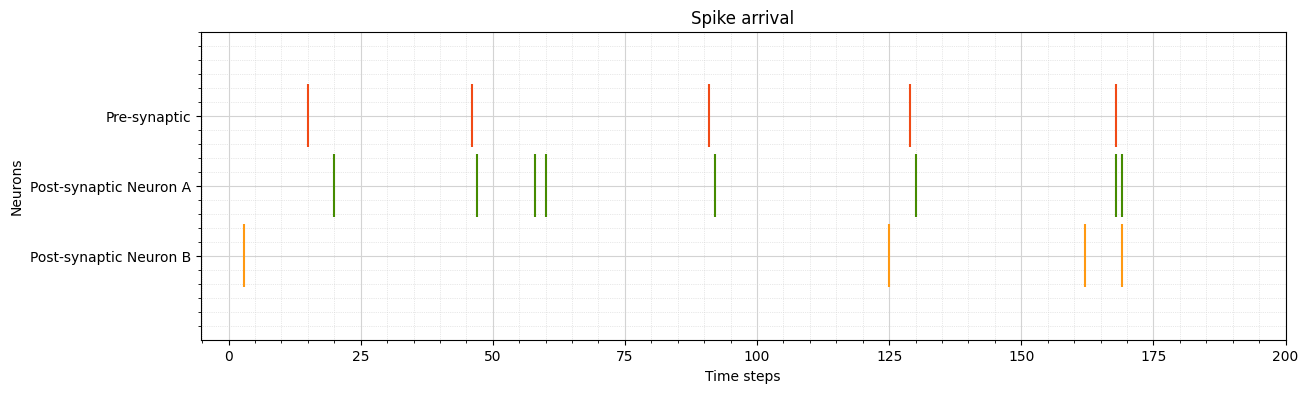

In [22]:
# Plot spikes
plot_spikes(spikes=[np.where(post_spikes[:, 1])[0], np.where(post_spikes[:, 0])[0], np.where(pre_spikes[:, 0])[0]],
            figsize=(14, 4),
            legend=['Post-synaptic Neuron B', 'Post-synaptic Neuron A', 'Pre-synaptic'], 
            colors=['#ff9912', 	'#458b00',  '#f14a16'],
            title='Spike arrival',
            num_steps=num_steps
            )

This plot shows the spike times at which the pre-synaptic neuron and the post-synaptic neurons 'A' and 'B' fired across time-steps. The co-relation between the spike timing of the pre-synaptic neuron and the post-synaptic neurons are used to do learning updates throughout the rest of the tutorial.  

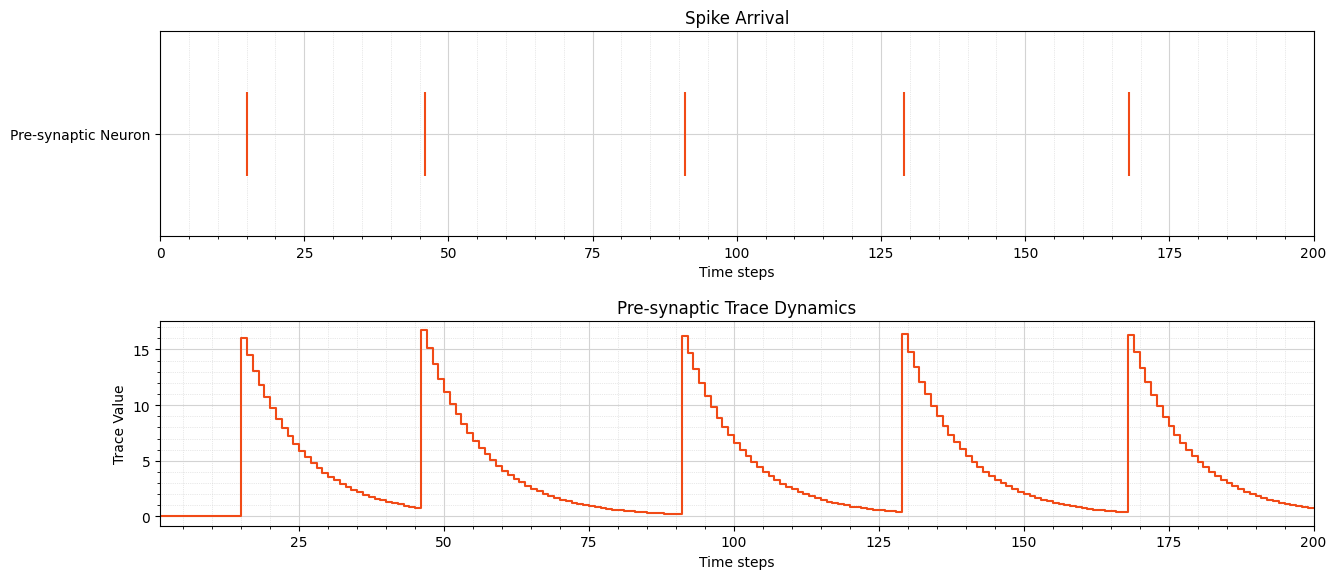

In [24]:
plot_spikes_time_series(time=time,
                        time_series=pre_trace,
                        spikes=[np.where(pre_spikes[:, 0])[0]],
                        figsize=(14, 6),
                        legend=['Pre-synaptic Neuron'], 
                        colors='#f14a16',
                        title=['Pre-synaptic Trace Dynamics'],
                        num_steps=num_steps
                        )

The first plot shows the spike times at which the pre-synaptic neuron fired. The pre-traces are updated based on the pre-synaptic spike train shown in the first plot. At the instant of a pre-synaptic spike, the pre-trace value is incremented by the 'pre_trace_kernel_magnitude' described in the learning rule. Subsequently, the trace value is decayed by a factor of 'pre_trace_decay_tau', with respect to the trace value at that instant, until the event of the next pre-synaptic spike. For example, the first pre-synaptic spike happens at time step 15 as shown in the first plot by the first red dash. Therefore, the pre-trace value is increamented by a value of 16 ('pre_trace_kernel_magnitude'), at time step 15, after which the decaying of the trace ensues until the next pre-synaptic spike at time step 46. Similar update dynamics are used to update the post-traces also. 

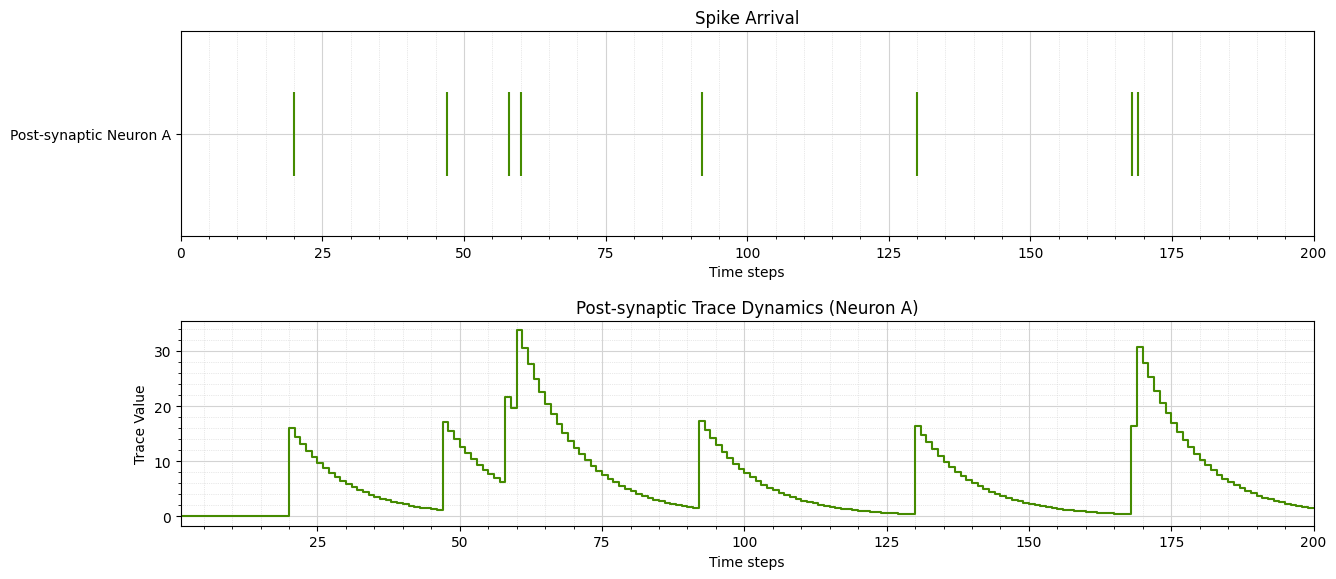

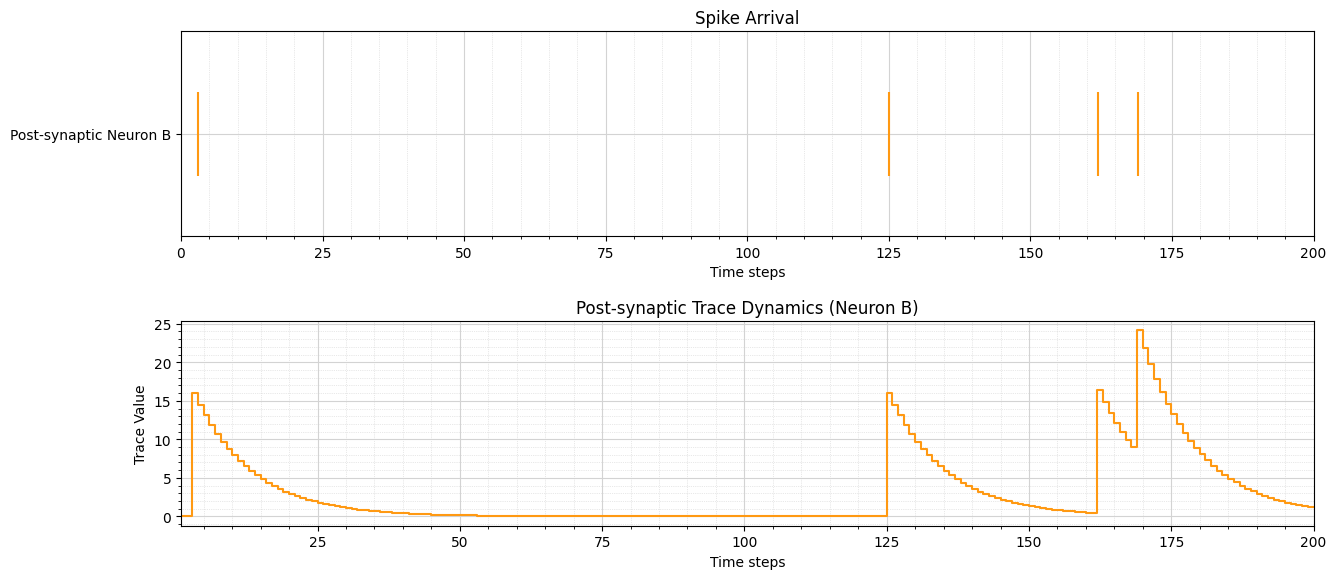

In [25]:
plot_spikes_time_series(time=time,
                        time_series=post_trace[:, 0],
                        spikes=[np.where(post_spikes[:, 0])[0]],
                        figsize=(14, 6),
                        legend=['Post-synaptic Neuron A'], 
                        colors='#458b00',
                        title=['Post-synaptic Trace Dynamics (Neuron A)'],
                        num_steps=num_steps
                        )

plot_spikes_time_series(time=time,
                        time_series=post_trace[:, 1],
                        spikes=[np.where(post_spikes[:, 1])[0]],
                        figsize=(14, 6),
                        legend=['Post-synaptic Neuron B'], 
                        colors='#ff9912',
                        title=['Post-synaptic Trace Dynamics (Neuron B)'],
                        num_steps=num_steps
                        )
                        

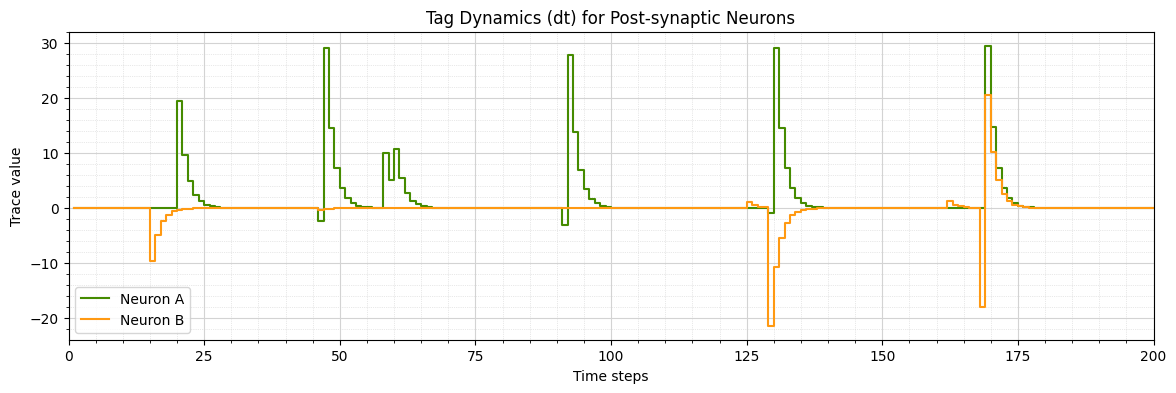

In [18]:
# Plotting tag dynamics (dt)
plot_time_series_subplots(time=time, 
                          time_series_y1=tag_neuron_A, 
                          time_series_y2=tag_neuron_B, 
                          ylabel="Trace value", 
                          title="Tag Dynamics (dt) for Post-synaptic Neurons", 
                          figsize=(14, 4), 
                          color=['#458b00', '#ff9912'], 
                          legend=['Neuron A', 'Neuron B'],
                          leg_loc="lower left"
                         )

The tag dynamics replicate the STDP learning rule with an additional decay behaviour to represent an eligibility trace. The update to the tag trace is based on the co-relation between pre and post-synaptic spikes. Consider the trace dynamics for 'Neuron A', the post-synaptic neuron A, fires at time-step 6, which is indicated by the first green dash in the 'spike arrival' plot. In Loihi 2, the update of the traces are done after both the pre-synaptic and post-synaptic neurons have fired. At the advent of pre-synaptic spike at time step 15, the tag trace of the post-synaptic neuron A which fired before the pre-synaptic neuron, is decremented by the dot product of the pre-trace value and the post-trace value at time step 15. This behaviour can be seen in the plot shown above. The evolution of the tag dynamics follows the same principle to do both depression and potentiation with respect to the co-relation between pre and post-spikes. 

#### Plot reward trace dynamics

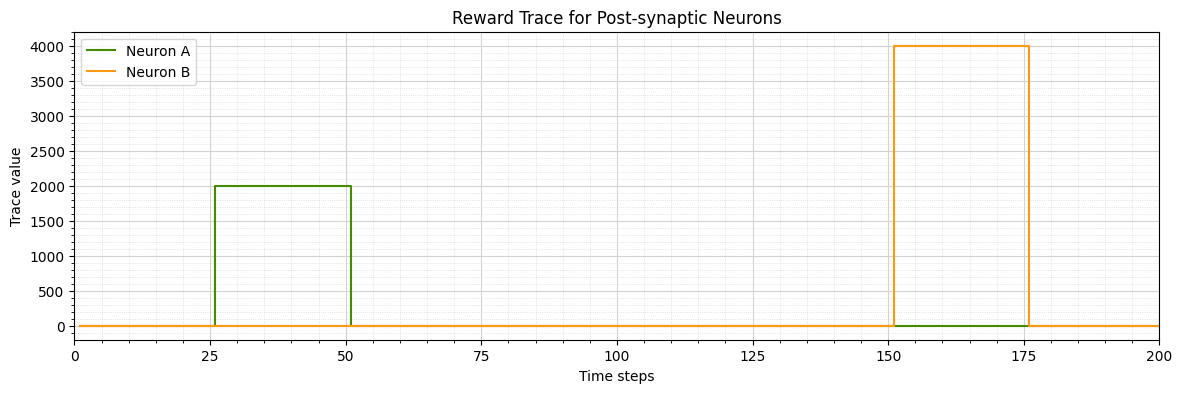

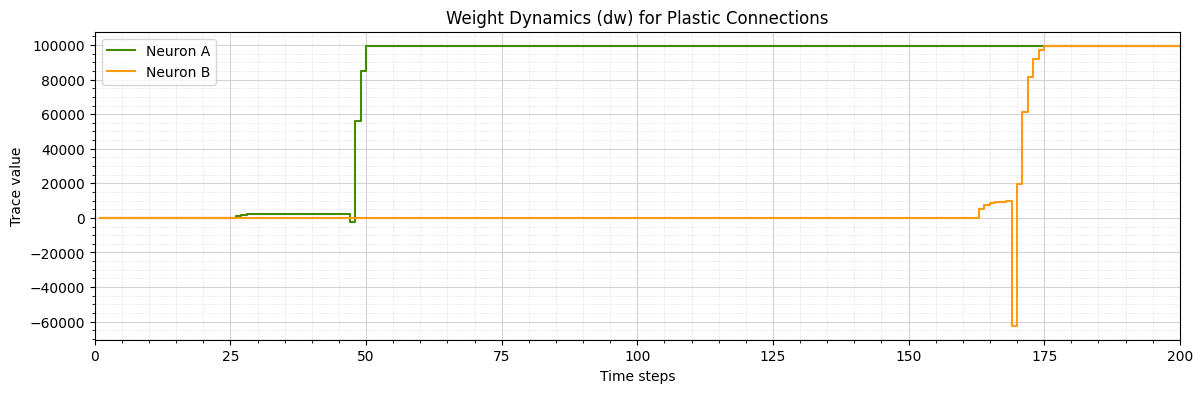

In [21]:
# Plotting reward trace dynamics
plot_time_series_subplots(time=time, 
                          time_series_y1=reward_trace[:, 0], 
                          time_series_y2=reward_trace[:, 1], 
                          ylabel="Trace value", 
                          title="Reward Trace for Post-synaptic Neurons", 
                          figsize=(14, 4), 
                          color=['#458b00', '#ff9912'], 
                          legend=['Neuron A', 'Neuron B']
                         )

# Plotting weight dynamics 
plot_time_series_subplots(time=time, 
                          time_series_y1=weights_neuron_A, 
                          time_series_y2=weights_neuron_B, 
                          ylabel="Trace value", 
                          title="Weight Dynamics (dw) for Plastic Connections", 
                          figsize=(14, 4), 
                          color=['#458b00', '#ff9912'], 
                          legend=['Neuron A', 'Neuron B']
                         )

In Loihi 2, individual post-synaptic neurons can be microcoded with reward traces that can be driven heterogeneously by synaptic inputs that differ in both magnitude and time. The reward trace plot shows the difference in third-factor trace received by the two-post synaptic neurons. The learnable synaptic weight is updated at every 't_epoch' based on the instantanious value of the eligibility trace and the reward trace. In an 'R-STDP' rule, the synaptic weight is updated only when a reward/third-factor value is non-zero. The weight dynamics of 'Neuron A' can be seen only being modified during the interval from time step 25 to time step 50, after which the weight trace value remains constant. This behaviour explains the functionality of the Reward-Modulated Spike-Timing Dependent Plasticity rule we defined in this tutorial.

### Advanced Topic: Implementing custom learning rule interfaces

The RewardModulatedSTDP Class maps R-STDP parameters to terms understood by Loihi's sum-of-product form learning engine. The eligibility trace $E$ can be stored in the tag variable $t$ of the Loihi learning engine. Tag dynamics $dt$ evolve according to 

$$dt = STDP(pre, post) - t \cdot \tau_{tag} \cdot u_0$$

where $\tau_{tag}$ is the time constant of the tag evolution. As described in the [STDP tutorial](../../in_depth/tutorial08_stdp.ipynb "Tutorial on STDP"), pairwise STDP dynamics $STDP(pre, post)$ can be re-defined using Loihi learning engine variables as

$$dt = ( A_{+} \cdot x_0 \cdot y_1 + A_{-} \cdot y_0 \cdot x_1 ) - t \cdot \tau_{tag} \cdot u_0$$

where $x_1$ and $y_1$ are the pre and postsynaptic spikes, $x_0$ and $y_0$ describe a rule execution dependence on the timing of the pre and postsynaptic spikes, respectively, and the spike timing behavior is scaled by the constants $A_{+} < 0$ and $A_{-} > 0$.

Weight evolution during learning $dw$ is a function of the tag dynamics $t$ and the reward signal, stored in Loihi's post-synaptic trace variable $y_2$:

$$dw = u_0 \cdot t \cdot y_2$$

$u_0$ is the Loihi learning engine's way of defining that the weight update occurs at every learning epoch.

The class structure of the RewardModulatedSTDP which converts the user readable variables to Loihi specific parameters and variables is described below. 

In [20]:
from lava.magma.core.learning.learning_rule import Loihi3FLearningRule
from lava.magma.core.learning.utils import float_to_literal


class RewardModulatedSTDP(Loihi3FLearningRule):
    def __init__(
            self,
            learning_rate: float,
            A_plus: float,
            A_minus: float,
            pre_trace_decay_tau: float,
            post_trace_decay_tau: float,
            pre_trace_kernel_magnitude: float,
            post_trace_kernel_magnitude: float,
            eligibility_trace_decay_tau: float,
            *args,
            **kwargs
    ):
        """
        Reward-Modulated Spike-timing dependent plasticity (STDP)
        as defined in Frémaux, Nicolas, and Wulfram Gerstner.
        "Neuromodulated spike-timing-dependent plasticity, and
        theory of three-factor learning rules." Frontiers in
        neural circuits 9 (2016).

        Parameters
        ==========

        learning_rate: float
            Overall learning rate scaling the intensity of weight changes.
        A_plus:
            Scaling the weight change on pre-synaptic spike times.
        A_minus:
            Scaling the weight change on post-synaptic spike times.
        pre_trace_decay_tau:
            Decay time constant of the pre-synaptic activity trace.
        post_trace_decay_tau:
            Decay time constant of the post-synaptic activity trace.
        pre_trace_kernel_magnitude:
            The magnitude of increase to the pre-synaptic trace value
            at the instant of pre-synaptic spike.
        post_trace_kernel_magnitude:
            The magnitude of increase to the post-synaptic trace value
            at the instant of post-synaptic spike.
        eligibility_trace_decay_tau:
            Decay time constant of the eligibility trace.

        """
        self.learning_rate = float_to_literal(learning_rate)
        self.A_plus = str(A_plus) if A_plus > 0 else f"({str(A_plus)})"
        self.A_minus = str(A_minus) if A_minus > 0 else f"({str(A_minus)})"
        self.pre_trace_decay_tau = pre_trace_decay_tau
        self.post_trace_decay_tau = post_trace_decay_tau
        self.pre_trace_kernel_magnitude = pre_trace_kernel_magnitude
        self.post_trace_kernel_magnitude = post_trace_kernel_magnitude
        self.eligibility_trace_decay_tau = \
            float_to_literal(eligibility_trace_decay_tau)

        # Trace impulse values
        x1_impulse = pre_trace_kernel_magnitude

        # Trace decay constants
        x1_tau = self.pre_trace_decay_tau

        # Eligibility trace represented as dt
        dt = f"{self.learning_rate} * {self.A_plus} * x0 * y1 +" \
             f"{self.learning_rate} * {self.A_minus} * y0 * x1 -" \
             f"u0 * t * {self.eligibility_trace_decay_tau}"

        # Reward-modulated weight update
        dw = " u0 * t * y2 "

        super().__init__(
            dw=dw,
            dt=dt,
            x1_impulse=x1_impulse,
            x1_tau=x1_tau,
            *args,
            **kwargs
        )

### How to learn more?

#### Follow the links below for deep-dive tutorials on the concepts in this tutorial:
- [Processes](../../in_depth/tutorial02_processes.ipynb "Tutorial on Processes")
- [ProcessModel](../../in_depth/tutorial03_process_models.ipynb "Tutorial on ProcessModels")
- [Execution](../../in_depth/tutorial04_execution.ipynb "Tutorial on Executing Processes")
- [Connecting Processes](../../in_depth/tutorial05_connect_processes.ipynb "Tutorial on connecting Processes")

If you want to find out more about Lava, have a look at the [Lava documentation](https://lava-nc.org/ "Lava Documentation") or dive into the [source code](https://github.com/lava-nc/lava/ "Lava Source Code").

To receive regular updates on the latest developments and releases of the Lava Software Framework please subscribe to the [INRC newsletter](http://eepurl.com/hJCyhb "INRC Newsletter").